# Gaussian Process on the Wiggle dataset
## Exact inference
### Need to remember to reset the document every time, the training procedure will just keep on getting lower and lower loss which in the end doesn't make sense

# Github

In [1]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/GPs


# Imports

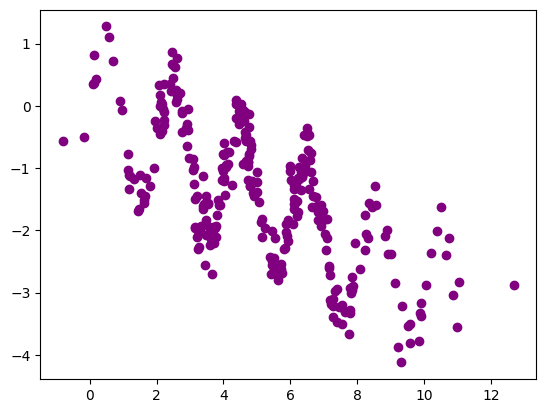

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    GPWiggle
	modified:   GPWiggle.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	GPWiggle (1).ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
#!pip install gpytorch
import gpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
%run ../datasets/wiggle.ipynb # Run the wiggle notebook which is in the same folder(Wiggle dataset)

# Training Data from wiggle

In [3]:
xTrain, yTrain = x, samples # x, samples are defined in ../datasets/wiggle.ipynb
xTrain, yTrain = torch.from_numpy(xTrain), torch.from_numpy(yTrain) # Convert them to tensors

# The GP model

In [4]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [5]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(xTrain, yTrain, likelihood) # For the first example, RBF kernel is used

# Train the Model

In [6]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) # Decide loss

training_iterations = 50 # Decide training iterations
for i in range(training_iterations):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(xTrain)
    # Calc loss and backprop gradients
    loss = -mll(output, xTrain)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iterations, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.677   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.540   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.415   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 1.300   lengthscale: 0.853   noise: 0.554
Iter 5/50 - Loss: 1.195   lengthscale: 0.910   noise: 0.513
Iter 6/50 - Loss: 1.097   lengthscale: 0.969   noise: 0.473
Iter 7/50 - Loss: 1.007   lengthscale: 1.029   noise: 0.436
Iter 8/50 - Loss: 0.922   lengthscale: 1.089   noise: 0.402
Iter 9/50 - Loss: 0.843   lengthscale: 1.150   noise: 0.369
Iter 10/50 - Loss: 0.767   lengthscale: 1.211   noise: 0.338
Iter 11/50 - Loss: 0.696   lengthscale: 1.272   noise: 0.310
Iter 12/50 - Loss: 0.627   lengthscale: 1.332   noise: 0.283
Iter 13/50 - Loss: 0.561   lengthscale: 1.392   noise: 0.259
Iter 14/50 - Loss: 0.497   lengthscale: 1.451   noise: 0.236
Iter 15/50 - Loss: 0.435   lengthscale: 1.509   noise: 0.215
Iter 16/50 - Loss: 0.375   lengthscale: 1.565   noise: 0.195
Iter 17/50 - Loss: 0.315   length

# Test Data

In [21]:
# Observing the plot of the wiggle dataset, x varies between -1-12
xTest = torch.linspace(-3, 15, 50)

# The posterior mean, variance and Covariance Matrix

In [22]:
model.eval() # eval mode is for computing predictions through the model posterior
f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
f_mean = f_preds.mean # Predictive mean
f_var = f_preds.variance # Predictive variance
f_covar = f_preds.covariance_matrix # Covariance matrix
#f_samples = f_preds.sample(sample_shape=torch.Size(1000,))
print("Mean Dimension: ", f_mean.size())
print()
print("Variance Dimension: ", f_var.size())
print()
print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([50])

Variance Dimension:  torch.Size([50])

CovMatrix Dimension  torch.Size([50, 50])


# Predictive Distribution

In [23]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()


# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

# Plot with RBF kernel

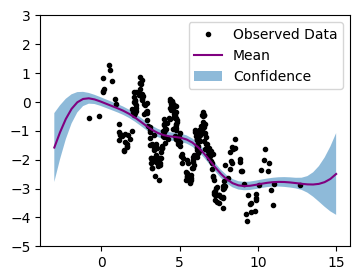

In [24]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(xTrain.numpy(), yTrain.numpy(), 'k.')
    # Plot predictive means as purple line
    ax.plot(xTest.numpy(), observed_pred.mean.numpy(), 'purple')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-5, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# GP with a periodic kernel instead

In [25]:
# Class for the GP model(Exact GP)
class GPModelPeriodic(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelPeriodic, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        # This kernel adds the RBF kernel with a Periodic kernel
        self.rbf_kernel = gpytorch.kernels.RBFKernel()
        self.periodic_kernel = gpytorch.kernels.PeriodicKernel()
        self.covar_module = gpytorch.kernels.ScaleKernel(self.rbf_kernel + self.periodic_kernel)
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood2 = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
modelPeriodic = GPModelPeriodic(xTrain, yTrain, likelihood2) # Now kernel is changed to periodic
# Set the hyperparameters for the Periodic Kernel
modelPeriodic.periodic_kernel.period_length = 5.0  # Set the period length to 10

# Train the periodic model

In [12]:
# Find optimal model hyperparameters
modelPeriodic.train()
likelihood2.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(modelPeriodic.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, modelPeriodic) # Decide loss

training_iterations = 50 # Decide training iterations
for i in range(training_iterations):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = modelPeriodic(xTrain)
    # Calc loss and backprop gradients
    loss = -mll(output, xTrain)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iterations, loss.item(),
        1, #modelPeriodic.covar_module.base_kernel.lengthscale.item()
        modelPeriodic.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.249   lengthscale: 1.000   noise: 0.693
Iter 2/50 - Loss: 1.170   lengthscale: 1.000   noise: 0.644
Iter 3/50 - Loss: 1.096   lengthscale: 1.000   noise: 0.598
Iter 4/50 - Loss: 1.025   lengthscale: 1.000   noise: 0.554
Iter 5/50 - Loss: 0.957   lengthscale: 1.000   noise: 0.513
Iter 6/50 - Loss: 0.892   lengthscale: 1.000   noise: 0.474
Iter 7/50 - Loss: 0.829   lengthscale: 1.000   noise: 0.437
Iter 8/50 - Loss: 0.769   lengthscale: 1.000   noise: 0.402
Iter 9/50 - Loss: 0.710   lengthscale: 1.000   noise: 0.370
Iter 10/50 - Loss: 0.653   lengthscale: 1.000   noise: 0.339
Iter 11/50 - Loss: 0.597   lengthscale: 1.000   noise: 0.311
Iter 12/50 - Loss: 0.542   lengthscale: 1.000   noise: 0.285
Iter 13/50 - Loss: 0.487   lengthscale: 1.000   noise: 0.260
Iter 14/50 - Loss: 0.434   lengthscale: 1.000   noise: 0.237
Iter 15/50 - Loss: 0.381   lengthscale: 1.000   noise: 0.216
Iter 16/50 - Loss: 0.328   lengthscale: 1.000   noise: 0.197
Iter 17/50 - Loss: 0.275   length

# The posterior mean, variance and Covariance Matrix

In [26]:
modelPeriodic.eval() # eval mode is for computing predictions through the model posterior
f_preds2 = modelPeriodic(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y

f_mean2 = f_preds2.mean # Predictive mean
f_var2 = f_preds2.variance # Predictive variance
f_covar2 = f_preds2.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean2.size())
print()
print("Variance Dimension: ", f_var2.size())
print()
print("CovMatrix Dimension ", f_covar2.size())

Mean Dimension:  torch.Size([50])

Variance Dimension:  torch.Size([50])

CovMatrix Dimension  torch.Size([50, 50])


# Predictive Distribution

In [27]:
modelPeriodic.eval() # eval mode is for computing predictions through the model posterior.
likelihood2.eval()
y_preds2 = likelihood2(modelPeriodic(xTest)) # gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred2 = y_preds2 # ---

# Plot the periodic GP

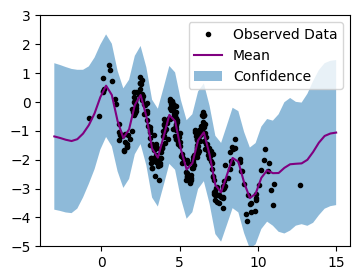

In [29]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred2.confidence_region()
    # Plot training data as black stars
    ax.plot(xTrain.numpy(), yTrain.numpy(), 'k.')
    # Plot predictive means as blue line
    ax.plot(xTest.numpy(), observed_pred2.mean.numpy(), 'purple')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-5, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [30]:
!git

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    GPWiggle
	modified:   GPWiggle.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	GPWiggle (1).ipynb

no changes added to commit (use "git add" and/or "git commit -a")
